<a href="https://colab.research.google.com/github/dmika1234/dl_uwr/blob/develop/Assignments/Assignment3/colab_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, settings

In [1]:
%pylab inline
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Torch has to go first due to an importing bug
import collections
import logging
import os
import re

import httpimport
import numpy as np
import PIL
import scipy.io
import scipy.ndimage
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.autograd import Variable

logging.getLogger("PIL").setLevel(logging.INFO)


with httpimport.github_repo(
    "janchorowski", "nn_assignments", "nn18"
):
    import common.plotting

In [3]:
# Colab
# %load_ext autoreload
# %autoreload
with httpimport.github_repo(
     "dmika1234", "dl_uwr", "develop"
):
     from Assignments.Assignment3.funs import VGG, VGGPreprocess, ILSVRC2014Sample, to_tensor, to_np

In [4]:
# On GPU enabled devices set device='cuda' else set device='cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CUDA = device.type == 'cuda'
CUDA

True

In [5]:
![ -e ilsvrc_subsample.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=1Y9xfTe9rjvFiX5N9DZqCRm83zHtQUBDC' -O ilsvrc_subsample.tar.bz2
![ -d ilsvrc_subsample ] || tar jxf ilsvrc_subsample.tar.bz2

Downloading...
From: https://drive.google.com/uc?id=1Y9xfTe9rjvFiX5N9DZqCRm83zHtQUBDC
To: /content/ilsvrc_subsample.tar.bz2
100% 25.5M/25.5M [00:00<00:00, 38.9MB/s]


# Test

In [6]:
vgg = VGG("vgg19")
if CUDA:
    vgg.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 239MB/s]


In [7]:
# List layers in the model
print("Feature layers")
print("--------------")
for name, layer in zip(vgg.feature_names, vgg.features):
    print("{1: <12} {0: <8}  ({2}".format(name, *str(layer).split("(", 1)))
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace=True)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace=True)
MaxPool2d    pool1     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace=True)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace=True)
MaxPool2d    pool2     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace=True)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace=True)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride

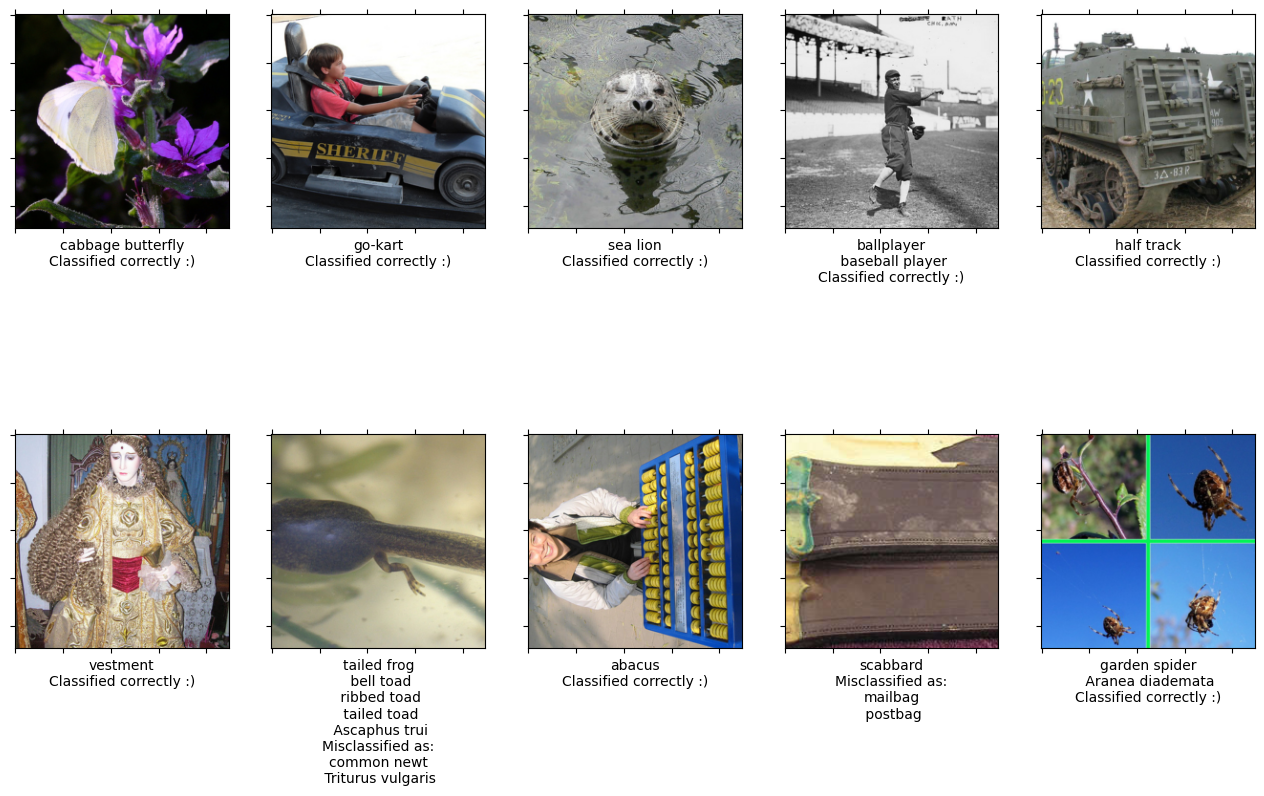

In [15]:
ilsvrc = ILSVRC2014Sample(40)
vgg.eval()

figsize(16, 10)
for i in range(10):
    img = ilsvrc.data[30 + i]
    label = ilsvrc.labels[30 + i]

    img_torch = to_tensor(img)

    predicted_label_id = to_np(vgg.predict(img_torch)).reshape(-1)[0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]

    desc = ilsvrc.label_to_desc[label].split(",")
    if label == predicted_label:
        desc.append("Classified correctly :)")
    else:
        desc.append("Misclassified as:")
        desc.extend(ilsvrc.label_to_desc[predicted_label].split(","))

    ax = plt.subplot(2, 5, 1 + i)
    ax.set_xlabel("\n".join(desc))  # , {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis="both", which="both", bottom="off", left="off", top="off")
    ax.grid(False)
    plt.imshow(img)

# Problem 1

## 1.

In [43]:
sample_img_dir = 'Sample_imgs/'
sample_imgs = [f for f in os.listdir(sample_img_dir)]

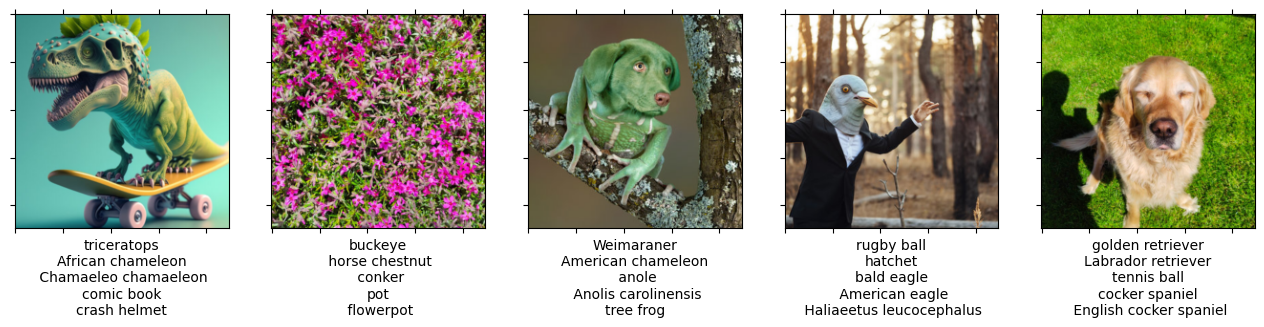

In [44]:
figsize(16, 10)
i = 0
for sample_img in sample_imgs:
  img = ilsvrc.load_image(sample_img_dir + sample_img)
  img_torch = to_tensor(img)

  predicted_label_id = to_np(vgg.predict(img_torch, k=5)).reshape(-1)
  predicted_labels = []
  for id in predicted_label_id:
    predicted_label = ilsvrc.id_to_label[id]
    predicted_labels.extend(ilsvrc.label_to_desc[predicted_label].split(","))
  predicted_labels = predicted_labels[0:5]

  ax = plt.subplot(2, 5, 1 + i)
  ax.set_xlabel("\n".join(predicted_labels))  # , {'verticalalignment': 'bottom'})
  ax.set_xticklabels([], visible=False)
  ax.set_yticklabels([], visible=False)
  ax.tick_params(axis="both", which="both", bottom="off", left="off", top="off")
  ax.grid(False)
  plt.imshow(img)
  i += 1